In [1]:
import paths as paths
import shared.locals as locals
from tinydb.queries import where
from helpers.config import Configuration
from database.models import ErrorLog, Project
from database.database import Database
from shared.calculation import query_and_calculate_ownership

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

results = {}
projects = database.query(Project.LABEL, where("log_groups") != [])

for project in projects:
    project_result = {}
    for error in database.query(ErrorLog.LABEL,
        (where("account") == "production") & (where("loggroup").one_of(project.log_groups))):

        ownership = query_and_calculate_ownership(database, project.id, error.timestamp)
        if not ownership in project_result:
            project_result[ownership] = 0
        project_result[ownership] += 1
    
    if project_result:
        results[project.id] = project_result

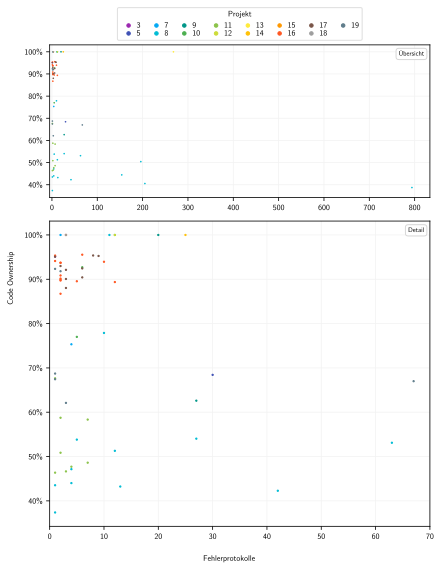

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(locals.TEXTWIDTH, locals.TEXTHEIGHT_SMALL),
    gridspec_kw={"height_ratios": [1, 2]})

for project_id, result in results.items():
    x = list(result.values())
    y = list(result.keys())

    ax1.scatter(x, y,
        color=locals.PROJECTS[project_id]["color"], marker='.', s=2, label=locals.PROJECTS[project_id]["id"], zorder=1)
    
    ax2.scatter(x, y,
        color=locals.PROJECTS[project_id]["color"], marker='.', s=8, label=locals.PROJECTS[project_id]["id"], zorder=1)

legend = ax1.legend(title="Projekt", loc="upper center", bbox_to_anchor=(0.5, 1.27),
    ncol=8, labelspacing=0.1, columnspacing=1, handletextpad=0, edgecolor=locals.FRAME_GRAY)
for handle in legend.legendHandles:
    handle.set_sizes([50])
legend._legend_box.sep = 4

props = dict(boxstyle="round", facecolor="white", edgecolor=locals.FRAME_GRAY, pad=0.4)
ax1.text(0.985, 0.96, "Übersicht", fontsize="small", bbox=props,
    horizontalalignment="right", verticalalignment="top", transform=ax1.transAxes)
ax2.text(0.985, 0.96, "Detail", fontsize="small", bbox=props,
    horizontalalignment="right", verticalalignment="bottom", transform=ax2.transAxes)

ax1.set_xlim(left=-5)
ax2.set_xlim([0,70])
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax1.grid(color=locals.GRID_GRAY)
ax2.grid(color=locals.GRID_GRAY)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

fig.text(0.5, -0.02, "Fehlerprotokolle", ha="center")
fig.text(-0.02, 0.5, "Code Ownership", va="center", rotation="vertical")

plt.tight_layout()
plt.show()